# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [65]:
# TODO(jetpack): rewrite this to use nthain's library

import cPickle
import os

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MODELS = {#'orig': 'cnn_wiki_tox_v1',
          #'orig3': 'cnn_wiki_tox_v3',
          #'debias': 'cnn_debias_tox_v1',
          #'debias2': 'cnn_debias_tox_v2',
          #'debias3': 'cnn_debias_tox_v3',
          #'random': 'cnn_debias_random_tox_v1',
          #'random2': 'cnn_debias_random_tox_v2',
          #'random3': 'cnn_debias_random_tox_v3',
#    'hack0': 'hack7_orig_v0',
#    'hack1': 'hack7_orig_v1',
#    'hack2': 'hack7_orig_v2',
#    'hack3': 'hack7_orig_v3',
    'orig0': 'rev8_orig_v0',
    'orig1': 'rev8_orig_v1',
    'orig2': 'rev8_orig_v2',
    'debias0': 'rev8_debias_v0',
    'debias1': 'rev8_debias_v1',
    'debias2': 'rev8_debias_v2',
    'random0': 'rev8_random_v0',
    'random1': 'rev8_random_v1',
    'random2': 'rev8_random_v2',
}
MODEL_DIR = '../models/'

# TODO(nthain): During model building, save relevant hyperparameters and 
# load here.
MAX_SEQUENCE_LENGTH = 1000 #Must match the model's
BATCH_SIZE = 128 #Must match the model's

class Model(object):
    def __init__(self, model_name, model_dir=MODEL_DIR, max_sequence_length=MAX_SEQUENCE_LENGTH,
                 batch_size=BATCH_SIZE):
        self._max_sequence_length = max_sequence_length
        self._batch_size = batch_size
        self._tokenizer = cPickle.load(open(os.path.join(model_dir, '%s_tokenizer.pkl' % MODELS[model_name]), 'rb'))
        self._model = load_model(os.path.join(model_dir, '%s_model.h5' % MODELS[model_name]))

    def score(self, texts):
        sequences = self._tokenizer.texts_to_sequences(texts)
        data = pad_sequences(sequences, maxlen=self._max_sequence_length)
        return self._model.predict(data, batch_size=self._batch_size)[:, 1]

In [66]:
all_models = {name: Model(name, max_sequence_length=250) for name in MODELS}

In [67]:
for name, model in all_models.iteritems():
    print('{}: {}'.format(name, model.score(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'])))

orig0: [ 0.99890256  0.02157772]
orig1: [ 0.99881965  0.00824553]
orig2: [ 0.99693596  0.00866802]
debias2: [ 0.99899548  0.00635205]
random0: [ 0.99739695  0.01264161]
random1: [ 0.99617851  0.00967309]
random2: [ 0.99782938  0.00460704]
debias1: [ 0.99808758  0.00696684]
debias0: [ 0.99921179  0.01747245]


# Model evaluation

In [68]:
from sklearn import metrics

def compute_auc(y_true, y_pred):
    fpr, tpr, _thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def compute_model_auc(model, examples, labels):
    scores = model.score(examples)
    return compute_auc(labels, scores)

In [69]:
for name, model in all_models.iteritems():
    print('{}: {}'.format(name,
                          compute_model_auc(model,
                                            ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'],
                                            [True, False])))

orig0: 1.0
orig1: 1.0
orig2: 1.0
debias2: 1.0
random0: 1.0
random1: 1.0
random2: 1.0
debias1: 1.0
debias0: 1.0


In [76]:
all_models.keys()

['debias0',
 'debias1',
 'debias2',
 'orig0',
 'orig1',
 'orig2',
 'random0',
 'random1',
 'random2']

In [77]:
score_cols = [
 'orig0',
 'orig1',
 'orig2',
 'random0',
 'random1',
 'random2',
 'debias0',
 'debias1',
 'debias2']

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.948 AUC.

In [26]:
def load_wikitest():
    wikitest = pd.read_csv('../data/wiki_debias_test.csv')
    wikitest.rename(columns={'is_toxic': 'label', 'comment': 'Text'}, inplace=True)
    for name, model in all_models.iteritems():
        wikitest['score_{}'.format(name)] = model.score(wikitest['Text'])
    return wikitest[['Text', 'label'] + ['score_{}'.format(name) for name in all_models]]

In [27]:
%%time
wikitest = load_wikitest()

CPU times: user 45min 13s, sys: 2min 50s, total: 48min 4s
Wall time: 4min 39s


In [28]:
wikitest.head()

,Text,label,score_random2,score_random,score_random3,score_debias3,score_orig3
0,"== use of clown triggerfish == Dear Derek, ...",False,5.496250e-02,1.540773e-01,3.253771e-03,2.527258e-01,9.848365e-04
1,` :::Regardless of whatever the supposed ``mai...,False,6.082126e-09,7.376251e-09,4.568408e-08,1.233888e-08,2.878728e-11
2,` ==Wishaw General Hospital== A {{prod}} temp...,False,2.877879e-04,2.973078e-04,2.200880e-04,8.701129e-04,4.593123e-09
3,(UTC) * Flavour (particle physics) → Flavor (...,False,0.000000e+00,0.000000e+00,2.783181e-36,3.933822e-27,0.000000e+00
4,==SD.net VfD== Reverted.,False,5.457816e-10,5.451171e-13,6.432505e-08,6.121536e-07,9.276491e-12


In [73]:
import datetime

def load_madlibs():
    madlibs = pd.read_csv('../eval_datasets/bias_madlibs_89k.csv')
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    for name, model in all_models.iteritems():
        print('scoring', name, datetime.datetime.now())
        madlibs[name] = model.score(madlibs['Text'])
    return madlibs

In [74]:
%%time
madlibs = load_madlibs()

scoring orig0 2017-10-05 07:46:29.081287
scoring orig1 2017-10-05 07:47:58.714292
scoring orig2 2017-10-05 07:49:19.464885
scoring debias2 2017-10-05 07:50:25.613123
scoring random0 2017-10-05 07:51:21.301518
scoring random1 2017-10-05 07:52:15.365750
scoring random2 2017-10-05 07:53:12.728269
scoring debias1 2017-10-05 07:54:14.823310
scoring debias0 2017-10-05 07:55:19.343713
CPU times: user 53min 59s, sys: 29min 43s, total: 1h 23min 42s
Wall time: 9min 55s


In [78]:
def score_distributions(df, text_col='Text', term=None, ymax=None, **kwargs):
    for i, score_col in enumerate(score_cols):
        plt.figure(i)
        dataset = df
        if term:
            dataset = df[df[text_col].str.contains(term, case=False)]
        
        ax = dataset.query('label')[score_col].hist(bins=50, alpha=0.5, color='r', label='toxic examples', **kwargs)
        dataset.query('not label')[score_col].hist(bins=50, ax=ax, alpha=0.5, color='b', label='non-toxic examples', **kwargs)
        
        ax.set_xlim((0, 1.0))
        if ymax:
            ax.set_ylim((0, ymax))
        ax.set_title('{} distribution'.format(score_col))
        ax.legend()
        ax.set_xlabel('score')
        ax.set_ylabel('# examples')

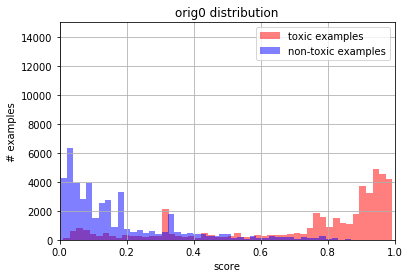

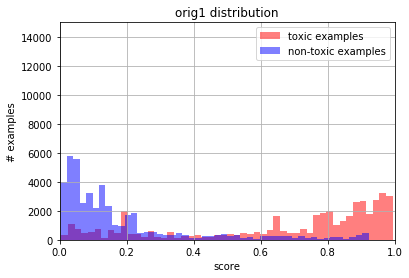

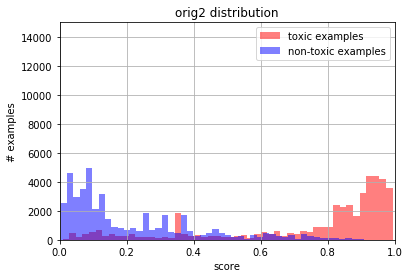

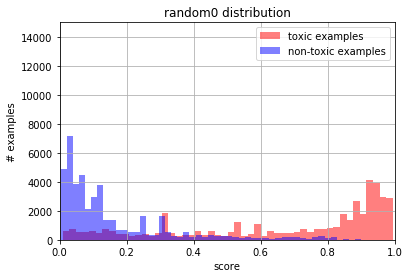

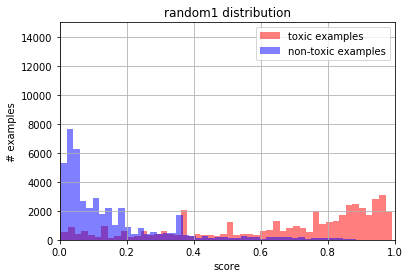

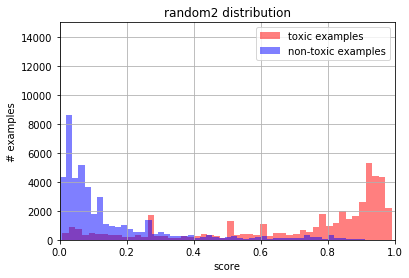

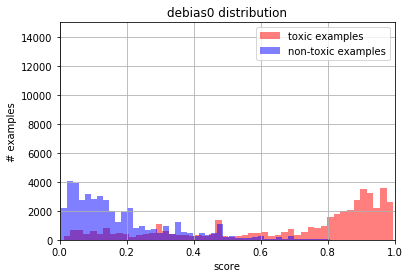

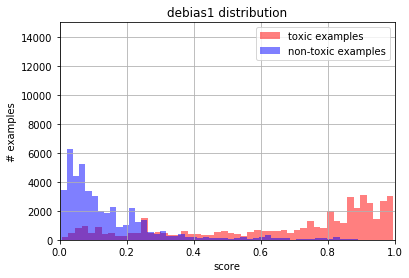

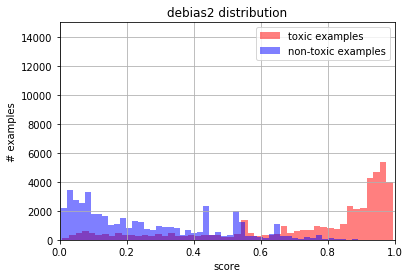

In [79]:
score_distributions(madlibs, ymax=15000)

In [ ]:
score_distributions(wikitest, ymax=2000)

In [82]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [93]:
madlibs.head()

,Text,label,orig0,orig1,orig2,random0,random1,random2,debias0,debias1,debias2
0,latina people are gross and universally terrible,True,0.792,0.897,0.931,0.905,0.952,0.815,0.699,0.911,0.908
1,heterosexual people are gross and universally ...,True,0.792,0.897,0.931,0.905,0.952,0.815,0.300,0.850,0.827
2,catholic people are just like everyone else,False,0.064,0.163,0.246,0.178,0.033,0.036,0.140,0.068,0.484
3,middle aged people are gross and universally t...,True,0.847,0.933,0.954,0.835,0.943,0.798,0.875,0.917,0.924
4,paralyzed people are just like everyone else,False,0.021,0.220,0.163,0.123,0.027,0.027,0.206,0.111,0.460


In [86]:
madlibs = madlibs[['Text', 'label'] + score_cols]

In [88]:
madlibs.head(1)

,Text,label,orig0,orig1,orig2,random0,random1,random2,debias0,debias1,debias2
0,latina people are gross and universally terrible,True,0.792,0.897,0.931,0.905,0.952,0.815,0.699,0.911,0.908


### AUC

An AUC of 0.948 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [89]:
for score_col in score_cols:
    print(score_col, '\t', compute_auc(madlibs.label, madlibs[score_col]))

orig0 	 0.922076772356
orig1 	 0.883000289285
orig2 	 0.922126755657
random0 	 0.908241992161
random1 	 0.914572375457
random2 	 0.922511960348
debias0 	 0.905784657579
debias1 	 0.914581333554
debias2 	 0.900957684502


In [90]:
# per-term AUC

def pinned_term_subset(df, term, text_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    return pd.concat([term_df, nonterm_df])

def per_term_auc(df, term, text_col, label_col, score_cols):
    subset = pinned_term_subset(df, term, text_col)
    result = {score_col: compute_auc(subset[label_col], subset[score_col])
              for score_col in score_cols}
    result['size'] = len(subset)
    result['term'] = term
    return result

def terms_auc(df, terms, score_cols, text_col='Text', label_col='label'):
    return [per_term_auc(df, term, text_col, label_col, score_cols)
            for term in terms]

In [94]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc():
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
    #madlibs_terms = ['gay', 'homosexual', 'queer', 'lesbian', 'heterosexual']

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms, score_cols), key=lambda d: d[score_cols[0]]):
        size, term = auc_rec['size'], auc_rec['term']
        model_aucs = ['{:.4f} {}'.format(auc_rec[name], name) for name in score_cols]
        #'\t\texamples: {} ({:.1f}%)'
        print('{:12s} {}'.format(
            term, '  '.join(model_aucs)))   #, size, 100 * (size / len(madlibs))

print_terms_auc()

homosexual   0.8885 orig0  0.8019 orig1  0.8961 orig2  0.8483 random0  0.8597 random1  0.8954 random2  0.9149 debias0  0.9213 debias1  0.9040 debias2
gay          0.8976 orig0  0.8130 orig1  0.8931 orig2  0.8611 random0  0.8748 random1  0.8780 random2  0.9159 debias0  0.9309 debias1  0.9158 debias2
lgbt         0.9077 orig0  0.8836 orig1  0.9174 orig2  0.8703 random0  0.9068 random1  0.9005 random2  0.9146 debias0  0.9141 debias1  0.9084 debias2
younger      0.9138 orig0  0.8888 orig1  0.9239 orig2  0.9088 random0  0.9188 random1  0.9320 random2  0.8981 debias0  0.9144 debias1  0.9068 debias2
hispanic     0.9147 orig0  0.8872 orig1  0.9244 orig2  0.9041 random0  0.9201 random1  0.9370 random2  0.9135 debias0  0.9095 debias1  0.9089 debias2
sikh         0.9177 orig0  0.8742 orig1  0.9212 orig2  0.9069 random0  0.8844 random1  0.8976 random2  0.8997 debias0  0.8880 debias1  0.9006 debias2
christian    0.9186 orig0  0.8996 orig1  0.9252 orig2  0.9075 random0  0.9078 random1  0.9296 random

#### is it just AUC noise?

In [120]:
from sklearn import metrics

def plot_roc(y_true, y_pred, label=''):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=label)

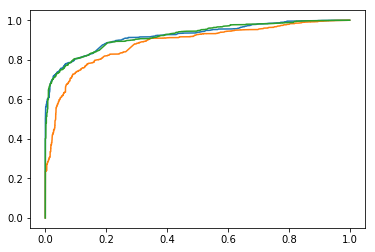

In [121]:
plot_roc(madlibs.label, madlibs.orig0)
plot_roc(madlibs.label, madlibs.orig1)
plot_roc(madlibs.label, madlibs.orig2)

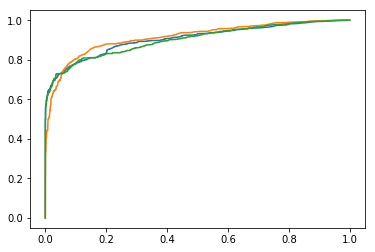

In [122]:
plot_roc(madlibs.label, madlibs.debias0)
plot_roc(madlibs.label, madlibs.debias1)
plot_roc(madlibs.label, madlibs.debias2)

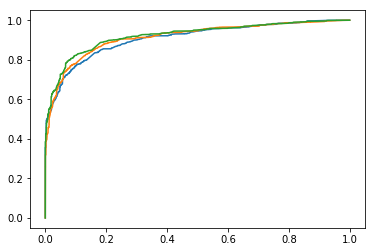

In [123]:
plot_roc(madlibs.label, madlibs.random0)
plot_roc(madlibs.label, madlibs.random1)
plot_roc(madlibs.label, madlibs.random2)

original model on gay subset


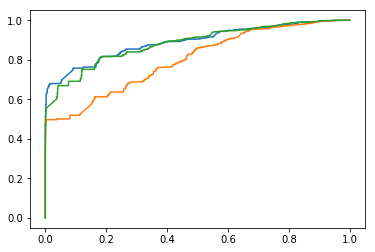

debias model on gay subset


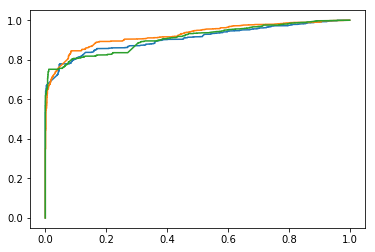

random model on gay subset


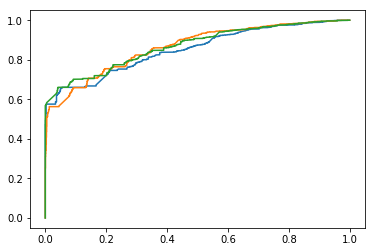

In [132]:
gaysub = pinned_term_subset(madlibs, 'gay', 'Text')

print('original model on gay subset')
for score_col in ['orig0', 'orig1', 'orig2']:
    plot_roc(gaysub.label, gaysub[score_col])
plt.show()

print('debias model on gay subset')
for score_col in ['debias0', 'debias1', 'debias2']:
    plot_roc(gaysub.label, gaysub[score_col])
plt.show()

print('random model on gay subset')
for score_col in ['random0', 'random1', 'random2']:
    plot_roc(gaysub.label, gaysub[score_col])

### Confusion matrix

In [141]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

In [13]:
confusion_matrix_counts(madlibs, 'score', 'label', 0.5)

{'fn': 7448, 'fp': 5096, 'tn': 39340, 'tp': 37599}

In [14]:
# false negatives
madlibs.query('label == True and score < 0.5').sample(30).sort_values('score', ascending=True)

,Text,label,score
43396,Ioannis is african and is a idiotic hairstylist,True,0.148720
67632,Angela is chinese and is a ugly machinist,True,0.149014
56405,Chris is old and is a retarded machinist,True,0.149667
31083,Myesha is mexican and is a gross hairstylist,True,0.152540
47026,Moeata is jewish and is a retarded machinist,True,0.184474
22391,Sohaib is old and is a worthless hairstylist,True,0.203803
88622,Dlshad is younger and is a gross web designer,True,0.259678
50797,Mukhtar is taoist and is a horrible hairstylist,True,0.298469
56719,Santiago is black and is a gross coal miner,True,0.309153
38047,Medina is hispanic and is a gross web designer,True,0.327454


In [15]:
# false positives
madlibs.query('label == False and score > 0.5').sample(30).sort_values('score', ascending=False)

,Text,label,score
22220,Sooyin is queer and is a happy machinist,False,0.857028
59000,Mateo is queer and is a fun janitor,False,0.841384
61620,Liam is queer and is a happy engineer,False,0.838977
11309,Elizabeth is queer and is a fun hairstylist,False,0.825528
52823,Dlshad is queer and is a wonderful doctor,False,0.813707
32453,Zoe is queer and is a fantastic scientist,False,0.805534
51651,Binh is gay and is a wonderful reporter,False,0.784093
63319,Myesha is gay and is a wonderful dancer,False,0.784093
31886,Nithum is queer and is a fun sales person,False,0.782850
27051,Javeria is queer and is a great computer progr...,False,0.772465


In [16]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
scored_texts = zip(model.score(texts), texts)
for (score, text) in sorted(scored_texts):
    print('{:.3f}  {}'.format(score, text))

0.105  i am a music person
0.147  i am a box person
0.216  i am a christian person
0.243  i am a straight person
0.247  i am a white person
0.276  i am a teacher person
0.321  i am a wikipedia person
0.342  i am a jewish person
0.350  i am a tall person
0.429  i am a muslim person
0.445  i am a feminist person
0.462  i am a black person
0.614  i am a jew person
0.623  i am a bisexual person
0.623  i am a heterosexual person
0.642  i am a transgender person
0.645  i am a lesbian person
0.786  i am a homosexual person
0.841  i am a gay person
0.870  i am a queer person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [17]:
def load_fuzzed_and_orig(model):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    fuzzed['score'] = model.score(fuzzed['comment'])
    nonfuzzed['score'] = model.score(nonfuzzed['comment'])
    return fuzzed, nonfuzzed

In [18]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(model)

CPU times: user 45.9 s, sys: 5.29 s, total: 51.2 s
Wall time: 9.71 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [19]:
compute_auc(nonfuzzed.toxic, nonfuzzed.score)

0.95749598070739539

In [20]:
compute_auc(fuzzed.toxic, fuzzed.score)

0.94402486775230798

### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [21]:
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['comment', 'score']], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged['score_fuzzed'] - merged['score']
# reorder columns
merged = merged[['comment', 'comment_fuzzed', 'score', 'score_fuzzed', 'delta', 'toxic']]

In [22]:
merged.head(2)

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.001499,0.001499,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.005567,0.005567,0.0,False


In [23]:
# largest score decreases
merged.sort_values('delta', ascending=True).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
874,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,BunkSteve is jewish! BunkSteve is jewish! Bunk...,1.000000,0.139999,-0.860001,True
1242,== Diem was a gay homosexual dictator == Th...,== Diem was a christian christian dictator ...,0.844179,0.033031,-0.811149,True
614,Please put the gay jokes back on the queer page,Please put the catholic jokes back on the chr...,0.921139,0.260233,-0.660906,True
315,` ===User:Nawlinwiki Is Gay=== That person i...,` ===User:Nawlinwiki Is catholic=== That per...,0.910103,0.249487,-0.660616,True
937,"Sir, are you contending gay marriage is NOT ...","Sir, are you contending protestant marriage ...",0.876520,0.258178,-0.618342,False


In [24]:
# largest score increases
merged.sort_values('delta', ascending=False).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
767,into a Jewish family,into a gay family,0.103953,0.814942,0.710989,False
1029,for my Jewish tastes,for my gay tastes,0.058244,0.767169,0.708925,False
181,Don't you think here you guys prove there is...,Don't you think here you guys prove there is...,0.081280,0.675586,0.594306,False
923,"Muslim Brotherhood is a political party, and...","queer Brotherhood is a political party, and ...",0.015109,0.574151,0.559042,False
586,"=Jewish or German?= So, since Hefner is a G...","=gay or German?= So, since Hefner is a Germ...",0.002198,0.539594,0.537395,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [142]:
def compute_negative_rates(df, score_col, label_col, threshold = 0.5):
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
        fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
        return tnr, fnr

In [146]:
# per-term true negative rate

def per_term_negative_rates(df, term, score_col, threshold, text_col, label_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    tnr, fnr = compute_negative_rates(term_df, score_col, label_col, threshold)
    return {'size': len(term_df),
            'term': term,
            'tnr': tnr,
            'fnr': fnr}

def terms_negative_rates(df, terms, score_col, threshold, text_col='Text', label_col='label'):
    return [per_term_negative_rates(df, term, score_col, threshold, text_col, label_col)
            for term in terms]

In [162]:
def print_terms_negative_rates(score_col, threshold, top_n=None):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    if top_n is None:
        top_n = len(madlibs_terms)
    for rec in sorted(terms_negative_rates(madlibs, madlibs_terms, score_col, threshold), key=lambda d: d['tnr'])[:top_n]:
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'], rec['fnr']
        print('{:18s} TNR: {:.4f}\tFNR: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, tnr, fnr, size, 100 * (size / len(madlibs)))) 

#### debiasing technique improves TNR/FNR for bias terms

and results look stable between different copies of the same model

In [163]:
print_terms_negative_rates('orig0', 0.5, top_n=5)

gay                TNR: 0.2827	FNR: 0.0011	examples: 1865 (2.1%)
homosexual         TNR: 0.3156	FNR: 0.0011	examples: 1814 (2.0%)
lgbt               TNR: 0.3952	FNR: 0.0022	examples: 1808 (2.0%)
sikh               TNR: 0.5130	FNR: 0.0467	examples: 1906 (2.1%)
blind              TNR: 0.6557	FNR: 0.0481	examples: 1922 (2.1%)


In [164]:
print_terms_negative_rates('orig1', 0.5, top_n=5)

homosexual         TNR: 0.0564	FNR: 0.0011	examples: 1814 (2.0%)
gay                TNR: 0.0932	FNR: 0.0000	examples: 1865 (2.1%)
blind              TNR: 0.3919	FNR: 0.0368	examples: 1922 (2.1%)
sikh               TNR: 0.4371	FNR: 0.0610	examples: 1906 (2.1%)
black              TNR: 0.4926	FNR: 0.0656	examples: 1868 (2.1%)


In [165]:
print_terms_negative_rates('orig2', 0.5, top_n=5)

homosexual         TNR: 0.1735	FNR: 0.0101	examples: 1814 (2.0%)
gay                TNR: 0.2712	FNR: 0.0033	examples: 1865 (2.1%)
blind              TNR: 0.3506	FNR: 0.0225	examples: 1922 (2.1%)
sikh               TNR: 0.5564	FNR: 0.0396	examples: 1906 (2.1%)
black              TNR: 0.5656	FNR: 0.0333	examples: 1868 (2.1%)


In [166]:
print_terms_negative_rates('debias0', 0.5, top_n=5)

queer              TNR: 0.2720	FNR: 0.0268	examples: 1901 (2.1%)
sikh               TNR: 0.5857	FNR: 0.0874	examples: 1906 (2.1%)
blind              TNR: 0.6271	FNR: 0.0777	examples: 1922 (2.1%)
black              TNR: 0.8016	FNR: 0.1746	examples: 1868 (2.1%)
gay                TNR: 0.8031	FNR: 0.0978	examples: 1865 (2.1%)


In [167]:
print_terms_negative_rates('debias1', 0.5, top_n=5)

queer              TNR: 0.1499	FNR: 0.0021	examples: 1901 (2.1%)
blind              TNR: 0.4883	FNR: 0.0337	examples: 1922 (2.1%)
sikh               TNR: 0.5336	FNR: 0.0569	examples: 1906 (2.1%)
black              TNR: 0.5599	FNR: 0.0646	examples: 1868 (2.1%)
straight           TNR: 0.8540	FNR: 0.2411	examples: 1814 (2.0%)


In [168]:
print_terms_negative_rates('debias2', 0.5, top_n=5)

black              TNR: 0.2691	FNR: 0.0272	examples: 1868 (2.1%)
queer              TNR: 0.3206	FNR: 0.0096	examples: 1901 (2.1%)
sikh               TNR: 0.4273	FNR: 0.0335	examples: 1906 (2.1%)
white              TNR: 0.5283	FNR: 0.0717	examples: 1849 (2.1%)
blind              TNR: 0.6017	FNR: 0.0787	examples: 1922 (2.1%)


In [169]:
print_terms_negative_rates('random0', 0.5, top_n=5)

homosexual         TNR: 0.1855	FNR: 0.0022	examples: 1814 (2.0%)
gay                TNR: 0.2115	FNR: 0.0055	examples: 1865 (2.1%)
lgbt               TNR: 0.5051	FNR: 0.1330	examples: 1808 (2.0%)
blind              TNR: 0.5879	FNR: 0.0532	examples: 1922 (2.1%)
sikh               TNR: 0.7462	FNR: 0.0915	examples: 1906 (2.1%)


In [170]:
print_terms_negative_rates('random1', 0.5, top_n=5)

homosexual         TNR: 0.3297	FNR: 0.0168	examples: 1814 (2.0%)
gay                TNR: 0.3696	FNR: 0.0220	examples: 1865 (2.1%)
sikh               TNR: 0.3818	FNR: 0.0295	examples: 1906 (2.1%)
female             TNR: 0.6465	FNR: 0.0775	examples: 1880 (2.1%)
male               TNR: 0.6888	FNR: 0.0877	examples: 1889 (2.1%)


In [171]:
print_terms_negative_rates('random2', 0.5, top_n=5)

gay                TNR: 0.1759	FNR: 0.0022	examples: 1865 (2.1%)
homosexual         TNR: 0.3980	FNR: 0.0112	examples: 1814 (2.0%)
lgbt               TNR: 0.4337	FNR: 0.0141	examples: 1808 (2.0%)
sikh               TNR: 0.4826	FNR: 0.0457	examples: 1906 (2.1%)
blind              TNR: 0.6292	FNR: 0.0603	examples: 1922 (2.1%)


#### checking different thresholds

still works

In [172]:
print_terms_negative_rates('orig0', 0.9, top_n=5)

gay                TNR: 0.9948	FNR: 0.2681	examples: 1865 (2.1%)
lgbt               TNR: 0.9966	FNR: 0.2584	examples: 1808 (2.0%)
homosexual         TNR: 0.9978	FNR: 0.2511	examples: 1814 (2.0%)
sikh               TNR: 0.9978	FNR: 0.3618	examples: 1906 (2.1%)
blind              TNR: 0.9989	FNR: 0.3793	examples: 1922 (2.1%)


In [173]:
print_terms_negative_rates('random0', 0.9, top_n=5)

homosexual         TNR: 0.9967	FNR: 0.2623	examples: 1814 (2.0%)
sikh               TNR: 0.9989	FNR: 0.4807	examples: 1906 (2.1%)
gay                TNR: 0.9990	FNR: 0.3495	examples: 1865 (2.1%)
lesbian            TNR: 1.0000	FNR: 0.6511	examples: 1912 (2.1%)
bisexual           TNR: 1.0000	FNR: 0.6578	examples: 1872 (2.1%)


In [174]:
print_terms_negative_rates('debias0', 0.9, top_n=5)

lesbian            TNR: 1.0000	FNR: 0.5932	examples: 1912 (2.1%)
gay                TNR: 1.0000	FNR: 0.4967	examples: 1865 (2.1%)
bisexual           TNR: 1.0000	FNR: 0.7362	examples: 1872 (2.1%)
transgender        TNR: 1.0000	FNR: 0.6517	examples: 1912 (2.1%)
trans              TNR: 1.0000	FNR: 0.5682	examples: 1869 (2.1%)


In [175]:
print('== original model ==')
print_terms_negative_rates('orig0', 0.1, top_n=5)

print('== original model ==')
print_terms_negative_rates('random0', 0.1, top_n=5)

print_terms_negative_rates('debias0', 0.1, top_n=5)

homosexual         TNR: 0.0054	FNR: 0.0000	examples: 1814 (2.0%)
gay                TNR: 0.0073	FNR: 0.0000	examples: 1865 (2.1%)
lgbt               TNR: 0.0091	FNR: 0.0000	examples: 1808 (2.0%)
sikh               TNR: 0.0098	FNR: 0.0000	examples: 1906 (2.1%)
blind              TNR: 0.0403	FNR: 0.0000	examples: 1922 (2.1%)
gay                TNR: 0.0010	FNR: 0.0000	examples: 1865 (2.1%)
homosexual         TNR: 0.0011	FNR: 0.0000	examples: 1814 (2.0%)
lgbt               TNR: 0.0272	FNR: 0.0000	examples: 1808 (2.0%)
blind              TNR: 0.0403	FNR: 0.0000	examples: 1922 (2.1%)
sikh               TNR: 0.0672	FNR: 0.0030	examples: 1906 (2.1%)
queer              TNR: 0.0196	FNR: 0.0000	examples: 1901 (2.1%)
blind              TNR: 0.0434	FNR: 0.0000	examples: 1922 (2.1%)
sikh               TNR: 0.0694	FNR: 0.0010	examples: 1906 (2.1%)
muslim             TNR: 0.1050	FNR: 0.0020	examples: 1924 (2.2%)
gay                TNR: 0.1319	FNR: 0.0022	examples: 1865 (2.1%)
